# Data analysis

## Folder structure requirements

For correct execution of this lab, your `/data` folder should be structured as follows:  
├── **data/**  
│&emsp;├── **raw/**  
│&emsp;│&emsp;├── *{dataset_name}*.csv  
│&emsp;│&emsp;├── *{dataset_name}*_names.txt  
│&emsp;│&emsp;├── *{dataset_name}*_categorical.txt  
│&emsp;│&emsp;└── *{dataset_name}*_numerical.txt  
│&emsp;└──  **processed/**  

## 1. Importing necessary libraries

We import all necessary libraries that will be necessary to read data files, analyze the data, conduct preprocessing and display desired visualizations.

In [1]:
import cfg
from read import read
from preprocess import set_variables_types, delete_columns_with_missing, delete_duplicate_rows, \
                       replace_missing, \
                       delete_highly_correlated_numeric, delete_highly_correlated_categoric, \
                       group_in_other, one_hot_encoding, delete_outliers
from exploration import get_missing_ratio, get_general_info, get_categorical_info, get_numerical_info, \
                        plot_categorical_distribution, plot_numerical_distribution, \
                        plot_pearson_correlation_matrix, plot_chi_2_matrix, get_outliers


import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

## 2. Reading the data

Reading the data is performed through the follwing steps:
1. We read data in the form of a `.csv` file.
2. We convert the data to a *Pandas* dataframe.
3. We extract column names from text file named `{name_of_dataset}_names.txt`, then we add them to the Pandas dataframe.
4. List of categorical and numerical variables should be found in the file: `{name_of_dataset}_categorical.txt` and `{name_of_dataset}_numerical.txt`, respectively.

In [2]:
df, numerical_vars, categorical_vars = read(name_of_dataset=cfg.NAME_OF_DATASET)

df.head()

,age,class of worker,industry code,occupation code,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## 3. Explore the structure of the data


**3.1.** We set variables to their appropriate type using user provided information, the type Pandas provide through numpy.dtype is not always consistent with the true type of the variable, like `industry code` variable would normally be considered numeric when  it's in fact categoric. 

In [3]:
df = set_variables_types(df, numerical_vars, categorical_vars)

**3.2.** We examine the ratio of missing values in each variable. Variables with a high ratio of missing values (e.g. > $85$) would be discarded here.  

It is not always the best course of action to delete such variables, sometimes it is better to replace missing values or make them a seperate category in case experts judged that their information is crucial for predicting the target variable.  

We notice that there are $7$ variables that meet the deletion condition: reason for unemployment: `enroll in edu inst last wk`, `state of previous residence`, `region of previous residence`, `migration prev res in sunbelt`, `member of a labor union`.

In [4]:
ratio = get_missing_ratio(df)
ratio = dict(sorted(ratio.items(), key=lambda item: item[1], reverse=True))
print("Ratio of missing values for each variable:")
for r in ratio:
    print(r + ": "+'{:.2f}'.format(ratio[r]))

Ratio of missing values for each variable:
fill inc questionnaire for veteran's admin: 0.99
reason for unemployment: 0.97
enroll in edu inst last wk: 0.94
state of previous residence: 0.92
region of previous residence: 0.92
migration prev res in sunbelt: 0.92
member of a labor union: 0.90
family members under 18: 0.72
migration code-change in msa: 0.51
migration code-change in reg: 0.51
migration code-move within reg: 0.51
major occupation code: 0.50
class of worker: 0.50
country of birth father: 0.03
country of birth mother: 0.03
country of birth self: 0.02
age: 0.00
industry code: 0.00
occupation code: 0.00
education: 0.00
wage per hour: 0.00
marital stat: 0.00
major industry code: 0.00
race: 0.00
hispanic Origin: 0.00
sex: 0.00
full or part time employment stat: 0.00
capital gains: 0.00
capital losses: 0.00
dividends from stocks: 0.00
tax filer stat: 0.00
detailed household and family stat: 0.00
detailed household summary in household: 0.00
instance weight: 0.00
live in this house 1

In [5]:
df, deleted = delete_columns_with_missing(df, missing_treshold=0.85)
print("Deleted variables: ", deleted)
print("Number of remaining variables: ", len(df.columns))
categorical_vars = list(set(categorical_vars) - set(deleted))
numerical_vars = list(set(numerical_vars) - set(deleted))

Deleted variables:  ['enroll in edu inst last wk', 'member of a labor union', 'reason for unemployment', 'region of previous residence', 'state of previous residence', 'migration prev res in sunbelt', "fill inc questionnaire for veteran's admin"]
Number of remaining variables:  35


**3.3.** For the remaining variables with missing values, we replace each missing value according to the variable's type as follows:  

1. For categorical variables, missing values are replaced with the mode (the most requent category) of that variable.
2. For numerical variables, missing values are replaced with the mean of that variable.

A value is deemed missing if one of the following indications is encountered: {` Not in universe`, ` ?`, ` Not identifiable`, `numpy.nan`}.

In [6]:
df = replace_missing(df, numerical_vars, categorical_vars)

**3.4.** Duplicate rows in a raw dataset can coincidental or the result of the human error during the gathering of the data. Duplicate rows may or may not affect the target predictions depending on the type of model we choose to train.  

In our case, we opt to delete all duplicate rows.

In [7]:
l = len(df)
df = delete_duplicate_rows(df)
print("number of duplicate rows found: ", l - len(df), "out of ", l)

number of duplicate rows found:  3331 out of  199523


**3.5.** Here, we diplay general information about our dataset resulting from the previous transformations, mainly: ***number of samples in the dataset, number of variables/features, the categorical and numerical variables***.

In [8]:
num_samples, num_features, numerical_vars, categorical_vars = get_general_info(df)

print("Number of samples: ", num_samples)
print("Number of features: ", num_features)
print("\nNumerical variables: ", numerical_vars)
print("\nCategorical variables: ", categorical_vars)

Number of samples:  196192
Number of features:  35

Numerical variables:  ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'instance weight', 'num persons worked for employer', 'weeks worked in year']

Categorical variables:  ['class of worker', 'industry code', 'occupation code', 'education', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic Origin', 'sex', 'full or part time employment stat', 'tax filer stat', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', 'veterans benefits', 'year', 'target']


**3.6.** We display more detailed information following the type of each variable:  

1. *For categorical variables*, we show: **the categories, their total number and the frequency distribution for each category**.
2. *For numerical variables*, we show: **the mean, median, important quartiles, min, max and standard deviation**.

Information about 'country of birth father':
+++++++++++++++++++++++++
Number of categories:  42
categories:  [' United-States', ' Vietnam', ' Philippines', ' Columbia', ' Germany', ' Mexico', ' Japan', ' Peru', ' Dominican-Republic', ' South Korea', ' Cuba', ' El-Salvador', ' Canada', ' Scotland', ' Outlying-U S (Guam USVI etc)', ' Italy', ' Guatemala', ' Ecuador', ' Puerto-Rico', ' Cambodia', ' China', ' Poland', ' Nicaragua', ' Taiwan', ' England', ' Ireland', ' Hungary', ' Yugoslavia', ' Trinadad&Tobago', ' Jamaica', ' Honduras', ' Portugal', ' Iran', ' France', ' India', ' Hong Kong', ' Haiti', ' Greece', ' Holand-Netherlands', ' Thailand', ' Laos']
Frequences:  country of birth father
United-States                   162640
Mexico                            9948
Puerto-Rico                       2676
Italy                             2212
Canada                            1380
Germany                           1356
Dominican-Republic                1284
Poland                     

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


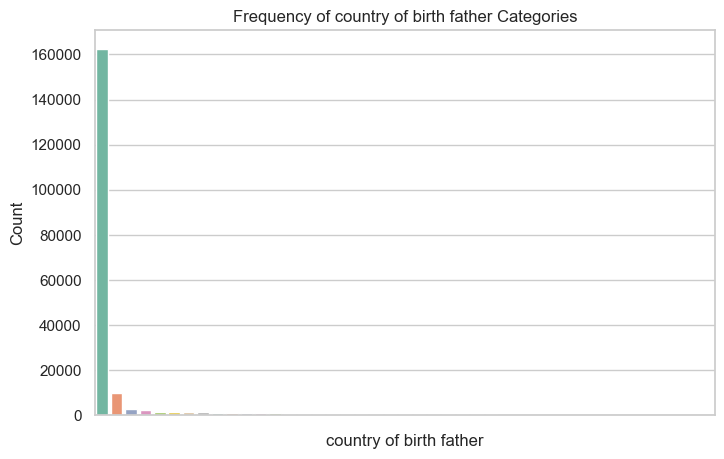

Information about 'detailed household summary in household':
+++++++++++++++++++++++++
Number of categories:  8
categories:  [' Other relative of householder', ' Householder', ' Child 18 or older', ' Child under 18 never married', ' Spouse of householder', ' Nonrelative of householder', ' Group Quarters- Secondary individual']
Frequences:  detailed household summary in household
Householder                             75457
Child under 18 never married            47225
Spouse of householder                   41684
Child 18 or older                       14413
Other relative of householder            9649
Nonrelative of householder               7585
Group Quarters- Secondary individual      132
Child under 18 ever married                47
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


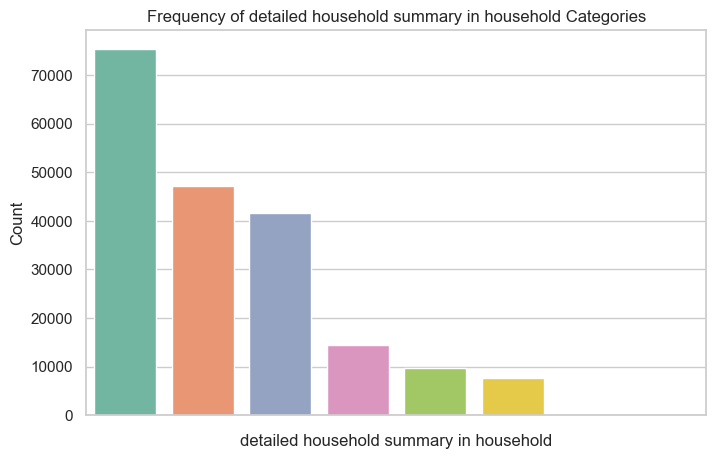

Information about 'industry code':
+++++++++++++++++++++++++
Number of categories:  52
categories:  [0, 4, 40, 34, 43, 37, 24, 39, 12, 35, 45, 3, 19, 29, 32, 48, 33, 23, 44, 36, 31, 30, 41, 5, 11, 9, 42, 6, 18, 50, 2, 1, 26, 47, 16, 14, 22, 17, 7, 8, 25, 46, 27, 15, 13, 49, 38, 21, 28, 20, 51]
Frequences:  industry code
0     97366
33    17068
43     8283
4      5984
42     4683
45     4482
29     4209
37     4022
41     3964
32     3594
35     3380
39     2937
34     2765
44     2547
2      2194
11     1764
50     1704
40     1650
47     1644
38     1629
24     1503
12     1350
19     1345
30     1181
31     1178
25     1084
9       992
22      952
36      945
13      899
1       827
48      652
27      626
49      610
3       563
21      559
6       554
5       553
8       550
16      539
23      525
18      483
15      452
7       422
14      295
46      186
17      157
28      143
26      126
51       36
20       32
10        4
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


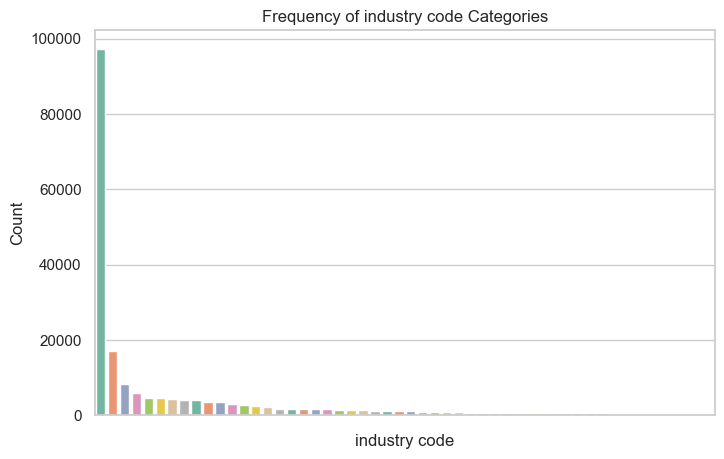

Information about 'migration code-change in reg':
+++++++++++++++++++++++++
Number of categories:  8
categories:  [' ?', ' Same county', ' Nonmover', ' Different region', ' Different county same state', ' Different division same region', ' Abroad']
Frequences:  migration code-change in reg
?                                 99368
Nonmover                          81092
Same county                        9779
Different county same state        2792
Different region                   1178
Different state same division       990
Abroad                              530
Different division same region      463
Not in universe                       0
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


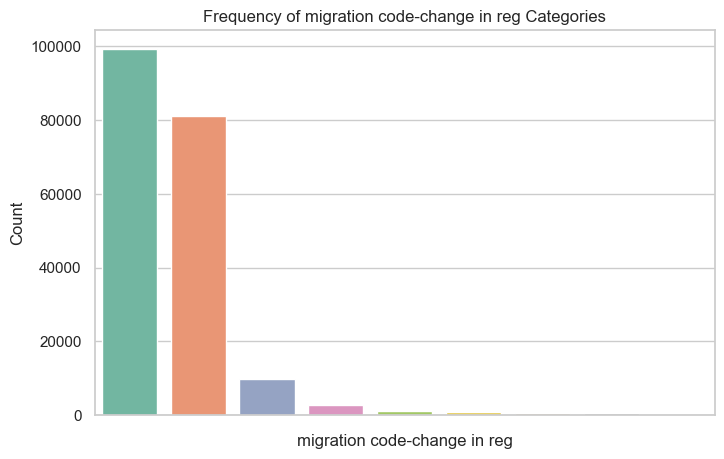

Information about 'family members under 18':
+++++++++++++++++++++++++
Number of categories:  5
categories:  [' Not in universe', ' Both parents present', ' Mother only present', ' Neither parent present']
Frequences:  family members under 18
Not in universe           144154
Both parents present       36019
Mother only present        12512
Father only present         1871
Neither parent present      1636
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


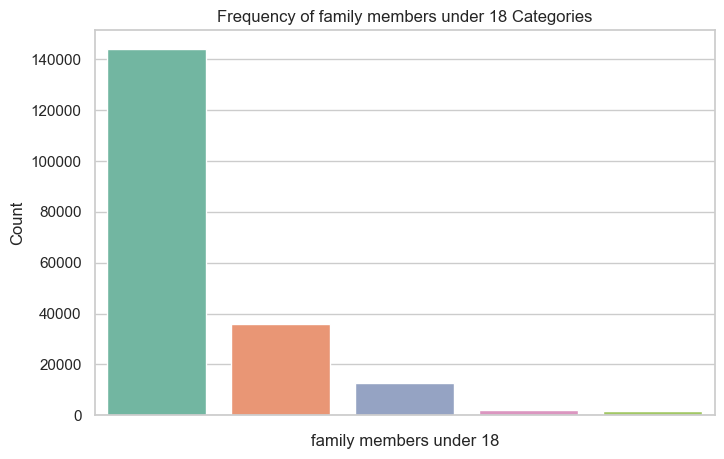

Information about 'migration code-change in msa':
+++++++++++++++++++++++++
Number of categories:  8
categories:  [' ?', ' MSA to MSA', ' Nonmover', ' NonMSA to nonMSA', ' Abroad to MSA', ' MSA to nonMSA', ' Abroad to nonMSA']
Frequences:  migration code-change in msa
?                   99798
Nonmover            81092
MSA to MSA          10572
NonMSA to nonMSA     2802
MSA to nonMSA         787
NonMSA to MSA         615
Abroad to MSA         453
Abroad to nonMSA       73
Not identifiable        0
Not in universe         0
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


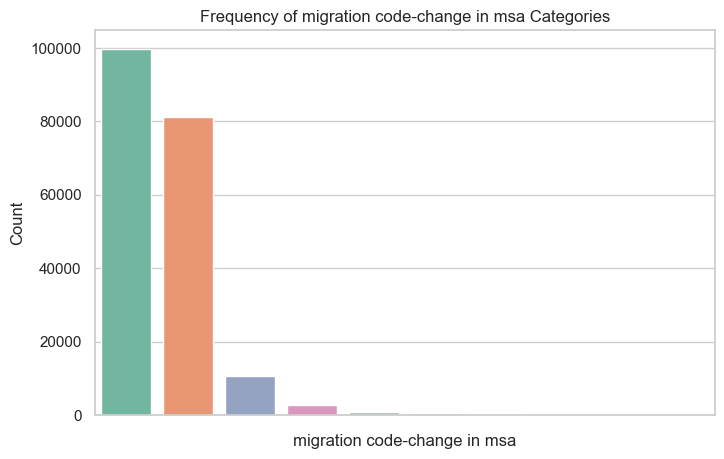

Information about 'country of birth mother':
+++++++++++++++++++++++++
Number of categories:  42
categories:  [' United-States', ' Vietnam', ' Columbia', ' Mexico', ' El-Salvador', ' Peru', ' Puerto-Rico', ' Cuba', ' Philippines', ' Dominican-Republic', ' Germany', ' England', ' Guatemala', ' Scotland', ' Portugal', ' Italy', ' Ecuador', ' Yugoslavia', ' China', ' Poland', ' Hungary', ' Nicaragua', ' Taiwan', ' Ireland', ' Canada', ' South Korea', ' Trinadad&Tobago', ' Jamaica', ' Honduras', ' Iran', ' France', ' Cambodia', ' India', ' Hong Kong', ' Haiti', ' Japan', ' Greece', ' Holand-Netherlands', ' Thailand', ' Panama', ' Laos']
Frequences:  country of birth mother
United-States                   163361
Mexico                            9721
Puerto-Rico                       2468
Italy                             1844
Canada                            1451
Germany                           1382
Philippines                       1228
Poland                            1109
El-Salvado

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


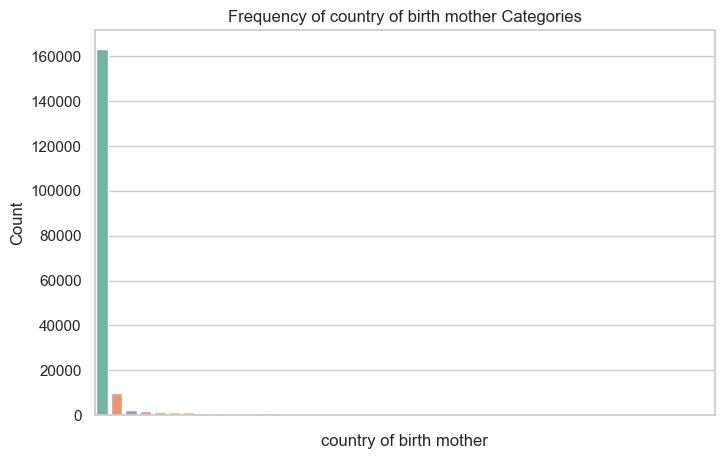

Information about 'veterans benefits':
+++++++++++++++++++++++++
Number of categories:  3
categories:  [2, 0]
Frequences:  veterans benefits
2    149965
0     44243
1      1984
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


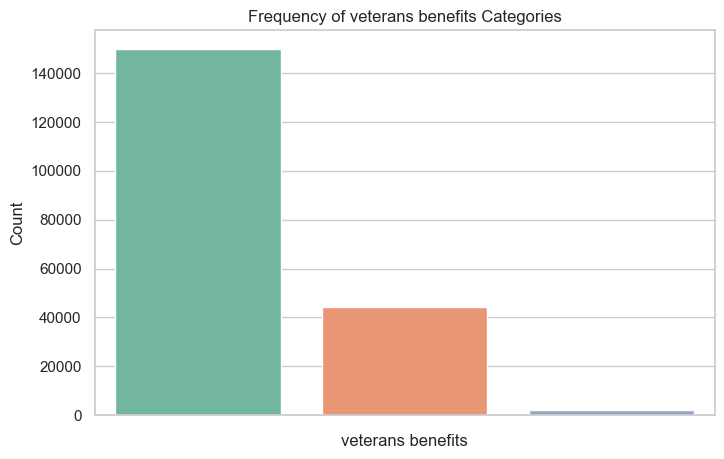

Information about 'citizenship':
+++++++++++++++++++++++++
Number of categories:  5
categories:  [' Native- Born in the United States', ' Foreign born- Not a citizen of U S ', ' Foreign born- U S citizen by naturalization', ' Native- Born abroad of American Parent(s)']
Frequences:  citizenship
Native- Born in the United States              173684
Foreign born- Not a citizen of U S              13385
Foreign born- U S citizen by naturalization      5851
Native- Born abroad of American Parent(s)        1753
Native- Born in Puerto Rico or U S Outlying      1519
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


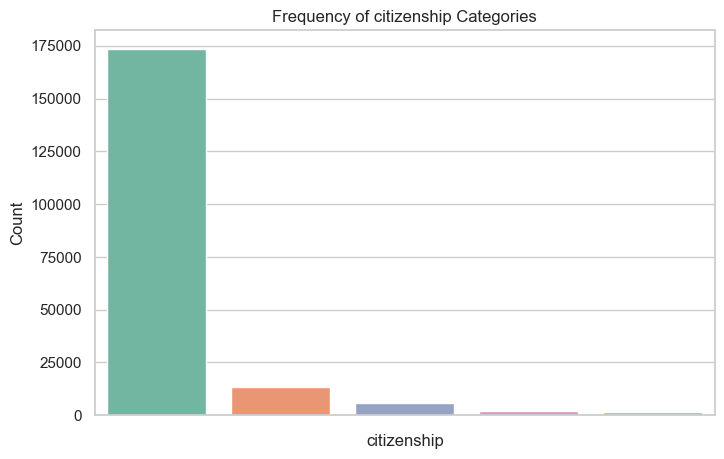

Information about 'education':
+++++++++++++++++++++++++
Number of categories:  17
categories:  [' High school graduate', ' Some college but no degree', ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)', ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade', ' Associates degree-academic program', ' 7th and 8th grade', ' 12th grade no diploma', ' Associates degree-occup /vocational', ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade', ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade']
Frequences:  education
High school graduate                      48369
Children                                  44256
Some college but no degree                27807
Bachelors degree(BA AB BS)                19859
7th and 8th grade                          7976
10th grade                                 7535
11th grade                                 6862
Masters degree(MA MS MEng MEd MSW MBA)     6540
9th grade                                  6193
Associates degre

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


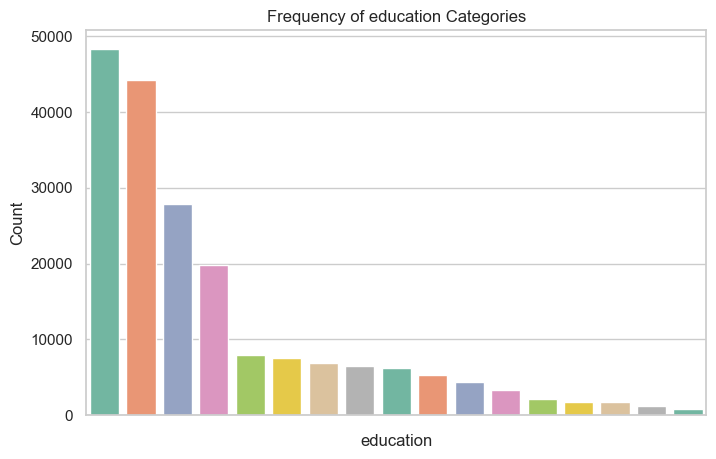

Information about 'sex':
+++++++++++++++++++++++++
Number of categories:  2
categories:  [' Female']
Frequences:  sex
Female    102345
Male       93847
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


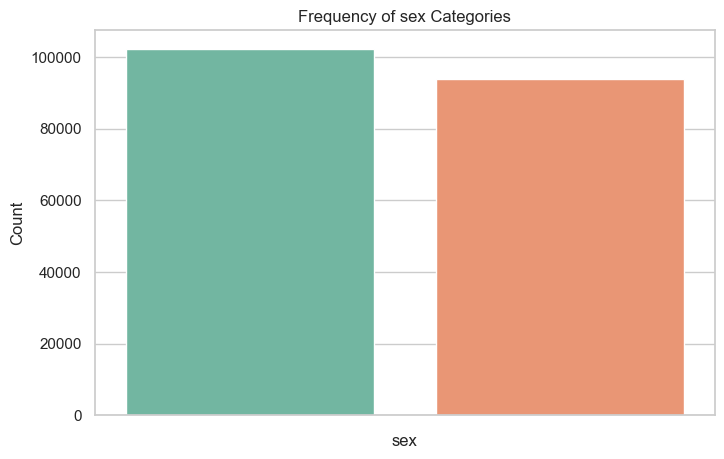

Information about 'year':
+++++++++++++++++++++++++
Number of categories:  2
categories:  [95]
Frequences:  year
94    98238
95    97954
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


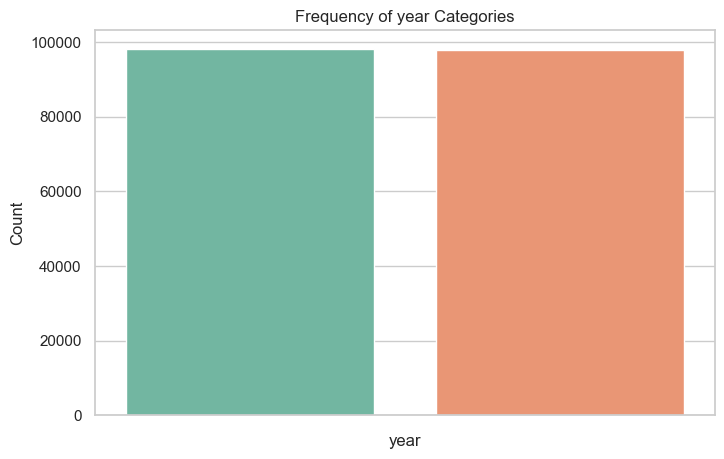

Information about 'occupation code':
+++++++++++++++++++++++++
Number of categories:  47
categories:  [0, 34, 10, 3, 40, 26, 37, 31, 12, 36, 41, 22, 2, 35, 25, 23, 42, 8, 19, 29, 27, 16, 33, 13, 18, 9, 17, 39, 32, 11, 30, 38, 20, 7, 21, 44, 24, 43, 28, 4, 1, 6, 45, 14, 5, 15]
Frequences:  occupation code
0     97366
2      8755
26     7886
19     5412
29     5105
36     4144
34     4025
10     3683
16     3445
23     3392
12     3340
33     3325
3      3195
35     3167
38     3003
31     2699
32     2396
37     2233
8      2151
42     1917
30     1897
24     1847
17     1771
28     1661
44     1592
41     1592
43     1380
4      1364
13     1271
18     1082
39     1017
14      932
5       855
15      815
27      780
25      767
9       738
7       731
11      637
40      617
1       544
21      533
6       441
22      411
45      171
20       71
46       36
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


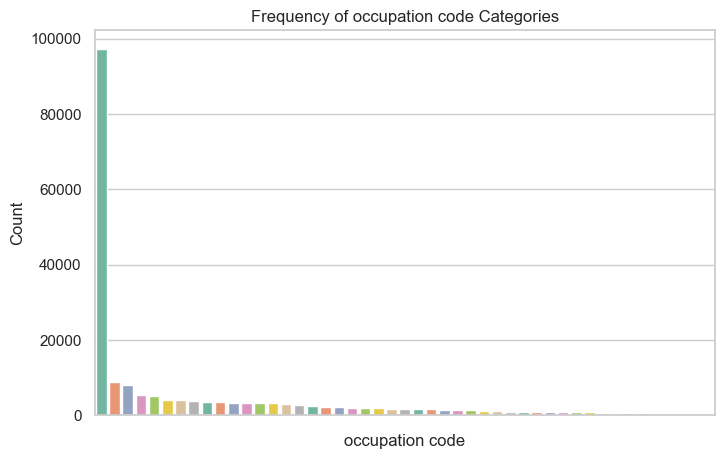

Information about 'hispanic Origin':
+++++++++++++++++++++++++
Number of categories:  10
categories:  [' All other', ' Do not know', ' Central or South American', ' Mexican (Mexicano)', ' Mexican-American', ' Other Spanish', ' Puerto Rican', ' Cuban', ' Chicano']
Frequences:  hispanic Origin
All other                    168703
Mexican-American               8006
Mexican (Mexicano)             7210
Central or South American      3891
Puerto Rican                   3306
Other Spanish                  2476
Cuban                          1122
NA                              870
Do not know                     305
Chicano                         303
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


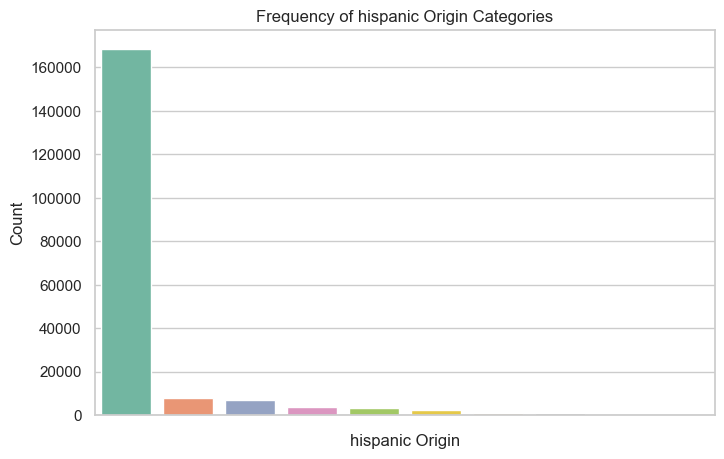

Information about 'country of birth self':
+++++++++++++++++++++++++
Number of categories:  42
categories:  [' United-States', ' Vietnam', ' Columbia', ' Mexico', ' Peru', ' Cuba', ' Philippines', ' Dominican-Republic', ' El-Salvador', ' Canada', ' Scotland', ' Portugal', ' Guatemala', ' Ecuador', ' Germany', ' Outlying-U S (Guam USVI etc)', ' Puerto-Rico', ' Italy', ' China', ' Poland', ' Nicaragua', ' Taiwan', ' England', ' Ireland', ' South Korea', ' Trinadad&Tobago', ' Jamaica', ' Honduras', ' Iran', ' Hungary', ' France', ' Cambodia', ' India', ' Hong Kong', ' Japan', ' Haiti', ' Holand-Netherlands', ' Greece', ' Thailand', ' Panama', ' Yugoslavia']
Frequences:  country of birth self
United-States                   177070
Mexico                            5759
Puerto-Rico                       1400
Germany                            850
Philippines                        844
Cuba                               836
Canada                             700
El-Salvador                  

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


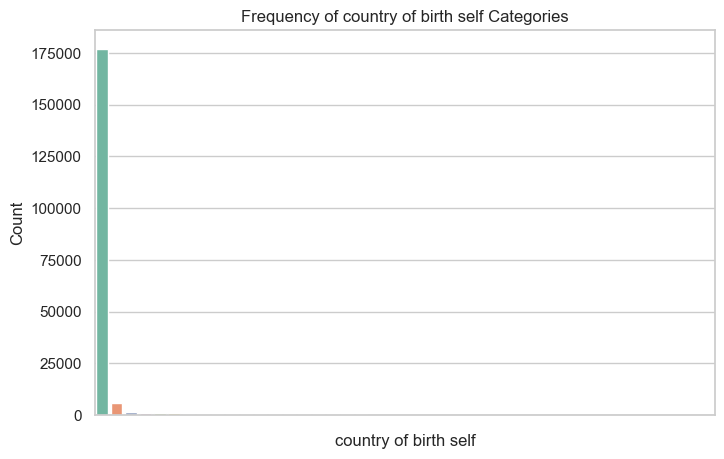

Information about 'marital stat':
+++++++++++++++++++++++++
Number of categories:  7
categories:  [' Widowed', ' Divorced', ' Never married', ' Married-civilian spouse present', ' Separated', ' Married-spouse absent']
Frequences:  marital stat
Married-civilian spouse present    84191
Never married                      83198
Divorced                           12707
Widowed                            10455
Separated                           3459
Married-spouse absent               1517
Married-A F spouse present           665
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


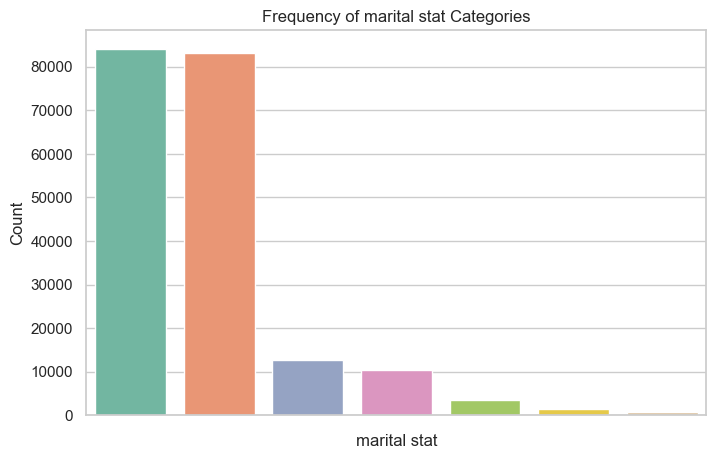

Information about 'detailed household and family stat':
+++++++++++++++++++++++++
Number of categories:  38
categories:  [' Other Rel 18+ ever marr not in subfamily', ' Householder', ' Child 18+ never marr Not in a subfamily', ' Child <18 never marr not in subfamily', ' Spouse of householder', ' Secondary individual', ' Other Rel 18+ never marr not in subfamily', ' Nonfamily householder', ' Grandchild <18 never marr not in subfamily', ' Grandchild <18 never marr child of subfamily RP', ' Child 18+ ever marr Not in a subfamily', ' Child 18+ never marr RP of subfamily', ' Child 18+ spouse of subfamily RP', ' Other Rel <18 never marr child of subfamily RP', ' Child under 18 of RP of unrel subfamily', ' Grandchild 18+ never marr not in subfamily', ' Child 18+ ever marr RP of subfamily', ' Other Rel 18+ ever marr RP of subfamily', ' RP of unrelated subfamily', ' Other Rel 18+ spouse of subfamily RP', ' Other Rel <18 never marr not in subfamily', ' Other Rel <18 spouse of subfamily RP', ' In

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


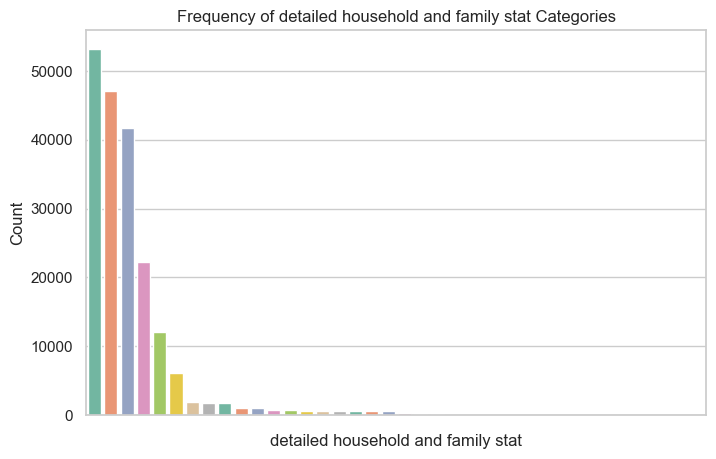

Information about 'class of worker':
+++++++++++++++++++++++++
Number of categories:  9
categories:  [' Not in universe', ' Self-employed-not incorporated', ' Private', ' Local government', ' Federal government', ' Self-employed-incorporated', ' State government', ' Never worked']
Frequences:  class of worker
Not in universe                   96928
Private                           72020
Self-employed-not incorporated     8442
Local government                   7783
State government                   4227
Self-employed-incorporated         3264
Federal government                 2925
Never worked                        438
Without pay                         165
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


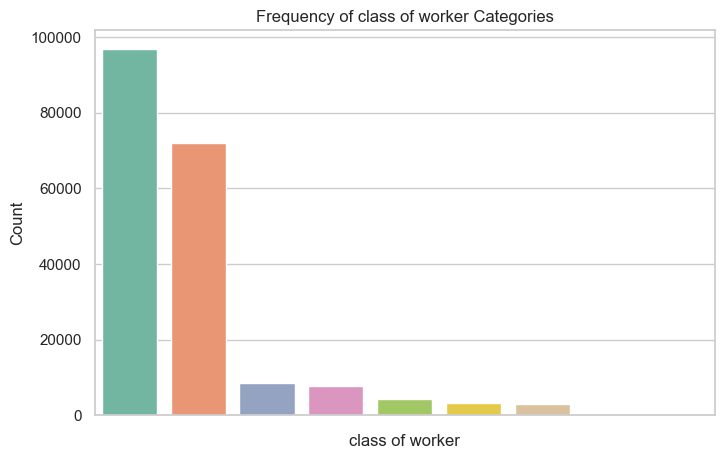

Information about 'target':
+++++++++++++++++++++++++
Number of categories:  2
categories:  [' - 50000.']
Frequences:  target
- 50000.    183810
50000+.      12382
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


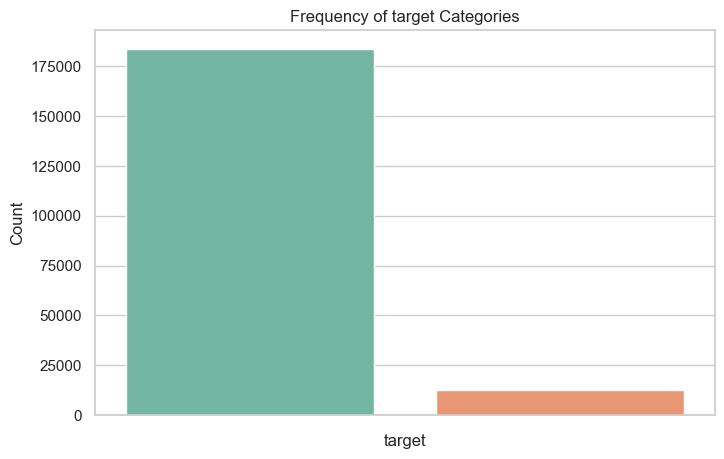

Information about 'full or part time employment stat':
+++++++++++++++++++++++++
Number of categories:  8
categories:  [' Not in labor force', ' Children or Armed Forces', ' Full-time schedules', ' Unemployed full-time', ' Unemployed part- time', ' PT for non-econ reasons usually FT', ' PT for econ reasons usually PT']
Frequences:  full or part time employment stat
Children or Armed Forces              120535
Full-time schedules                    40728
Not in labor force                     26721
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2310
PT for econ reasons usually PT          1209
Unemployed part- time                    842
PT for econ reasons usually FT           525
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


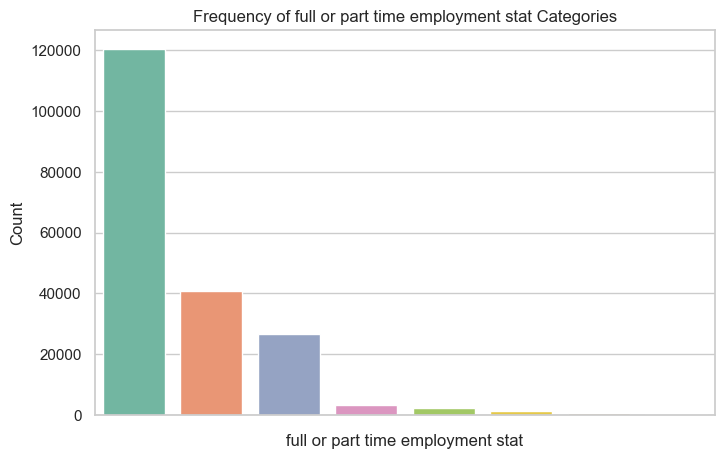

Information about 'major occupation code':
+++++++++++++++++++++++++
Number of categories:  15
categories:  [' Not in universe', ' Precision production craft & repair', ' Professional specialty', ' Executive admin and managerial', ' Handlers equip cleaners etc ', ' Adm support including clerical', ' Machine operators assmblrs & inspctrs', ' Other service', ' Sales', ' Private household services', ' Technicians and related support', ' Transportation and material moving', ' Farming forestry and fishing', ' Protective services']
Frequences:  major occupation code
Not in universe                          97366
Adm support including clerical           14836
Professional specialty                   13940
Executive admin and managerial           12494
Other service                            12097
Sales                                    11781
Precision production craft & repair      10517
Machine operators assmblrs & inspctrs     6377
Handlers equip cleaners etc               4126
Transporta

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


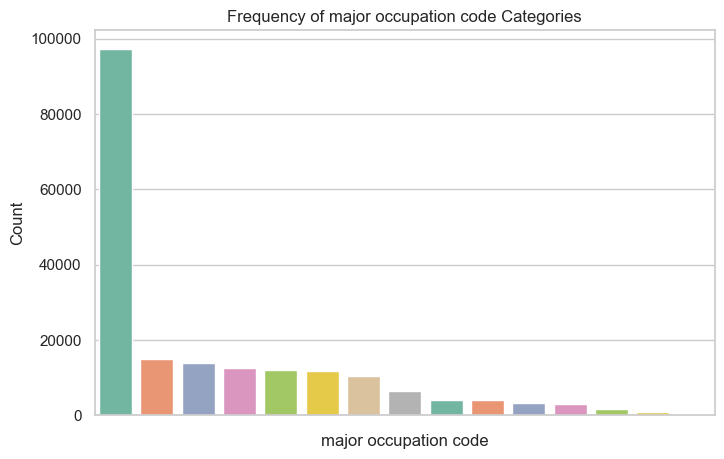

Information about 'migration code-move within reg':
+++++++++++++++++++++++++
Number of categories:  9
categories:  [' ?', ' Same county', ' Nonmover', ' Different state in South', ' Different county same state', ' Different state in Northeast', ' Abroad', ' Different state in Midwest']
Frequences:  migration code-move within reg
?                               99368
Nonmover                        81092
Same county                      9779
Different county same state      2792
Different state in South          972
Different state in West           678
Different state in Midwest        551
Abroad                            530
Different state in Northeast      430
Not in universe                     0
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


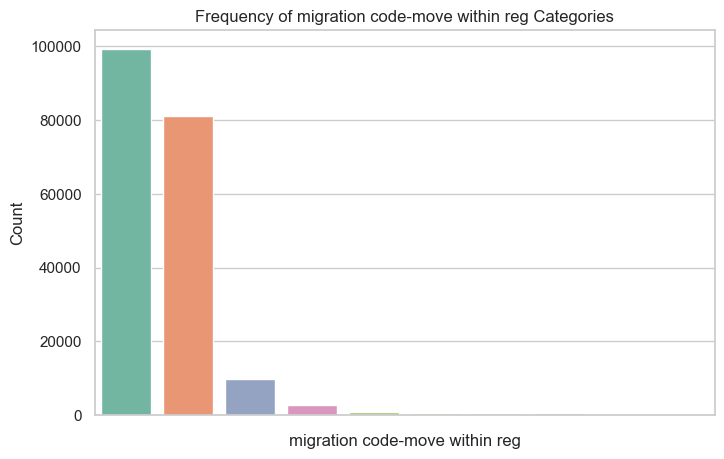

Information about 'live in this house 1 year ago':
+++++++++++++++++++++++++
Number of categories:  3
categories:  [' Not in universe under 1 year old', ' No']
Frequences:  live in this house 1 year ago
Not in universe under 1 year old    99368
Yes                                 81092
No                                  15732
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


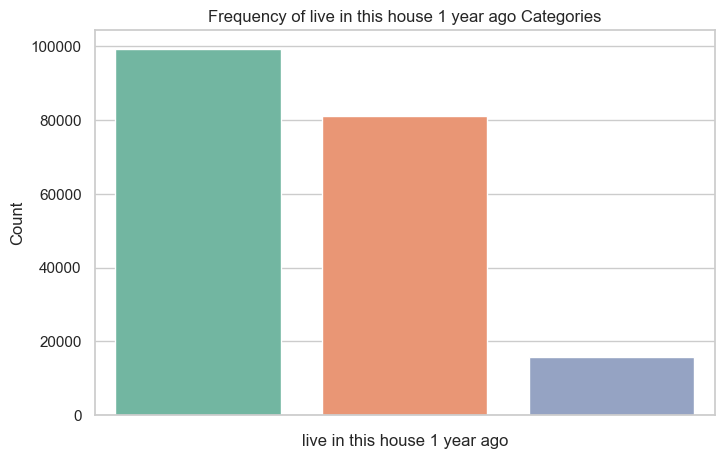

Information about 'own business or self employed':
+++++++++++++++++++++++++
Number of categories:  3
categories:  [0, 2]
Frequences:  own business or self employed
0    177343
2     16151
1      2698
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


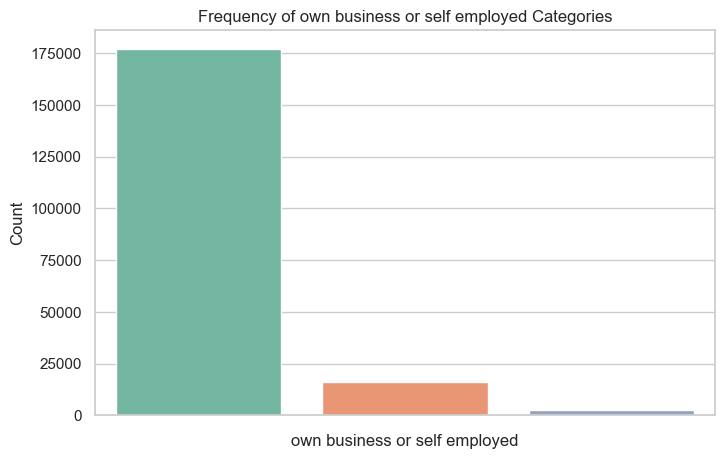

Information about 'tax filer stat':
+++++++++++++++++++++++++
Number of categories:  6
categories:  [' Nonfiler', ' Head of household', ' Joint both under 65', ' Single', ' Joint both 65+']
Frequences:  tax filer stat
Nonfiler                        71805
Joint both under 65             67367
Single                          37408
Joint both 65+                   8323
Head of household                7425
Joint one under 65 & one 65+     3864
Name: count, dtype: int64


D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


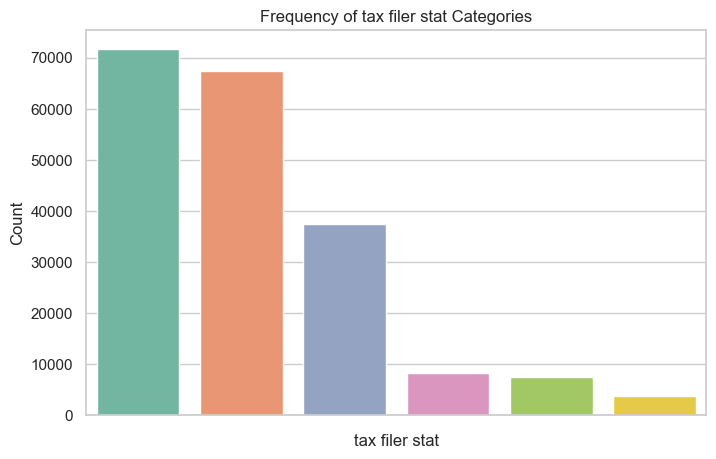

Information about 'major industry code':
+++++++++++++++++++++++++
Number of categories:  24
categories:  [' Not in universe or children', ' Construction', ' Entertainment', ' Finance insurance and real estate', ' Education', ' Business and repair services', ' Manufacturing-nondurable goods', ' Personal services except private HH', ' Manufacturing-durable goods', ' Other professional services', ' Mining', ' Transportation', ' Wholesale trade', ' Public administration', ' Retail trade', ' Social services', ' Private household services', ' Utilities and sanitary services', ' Communications', ' Hospital services', ' Medical except hospital', ' Agriculture', ' Forestry and fisheries']
Frequences:  major industry code
Not in universe or children            97366
Retail trade                           17068
Manufacturing-durable goods             9014
Education                               8283
Manufacturing-nondurable goods          6895
Finance insurance and real estate       6145
Constru

D:\M2\PYTHON\TP2\exploration.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=column, palette='Set2', order=order)


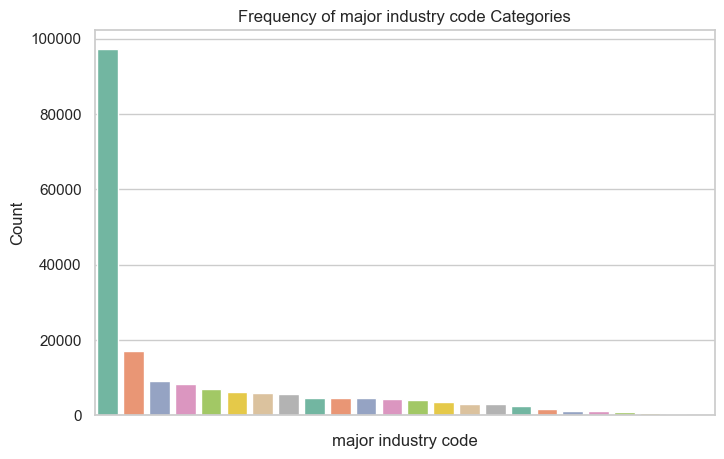

In [9]:
for v in categorical_vars:
    num_categories, categories, freq = get_categorical_info(df[v])
    print(f"Information about '{v}':")
    print("+++++++++++++++++++++++++")
    print("Number of categories: ", num_categories)
    print("categories: ", categories[:-1])
    print("Frequences: ", freq)
    plot_categorical_distribution(df, v)

count   196192.00
mean      1743.25
std        997.07
min         37.87
25%       1061.35
50%       1620.14
75%       2194.27
max      18656.30
Name: instance weight, dtype: float64


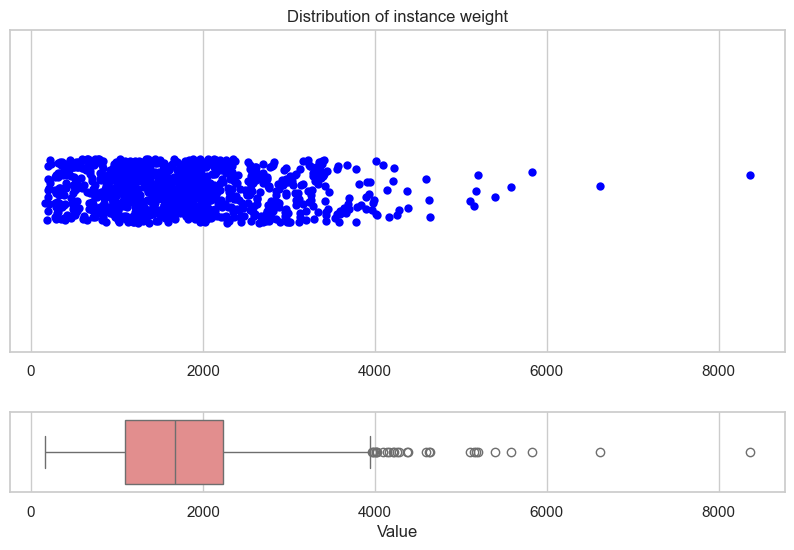

count   196192.00
mean        23.57
std         24.43
min          0.00
25%          0.00
50%         12.00
75%         52.00
max         52.00
Name: weeks worked in year, dtype: float64


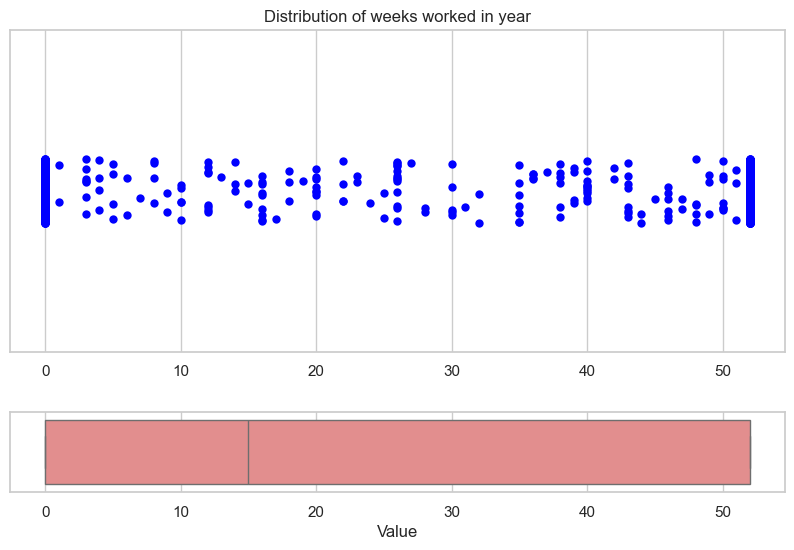

count   196192.00
mean        56.37
std        277.12
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       9999.00
Name: wage per hour, dtype: float64


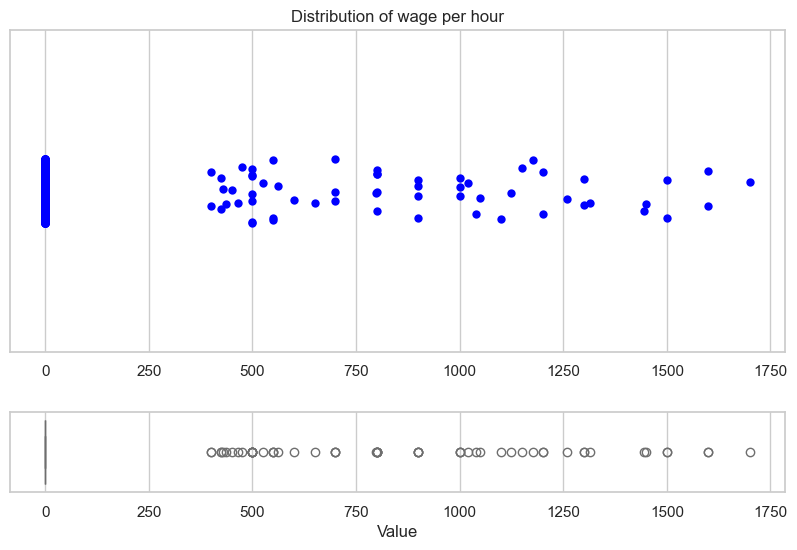

count   196192.00
mean       442.10
std       4736.90
min          0.00
25%          0.00
50%          0.00
75%          0.00
max      99999.00
Name: capital gains, dtype: float64


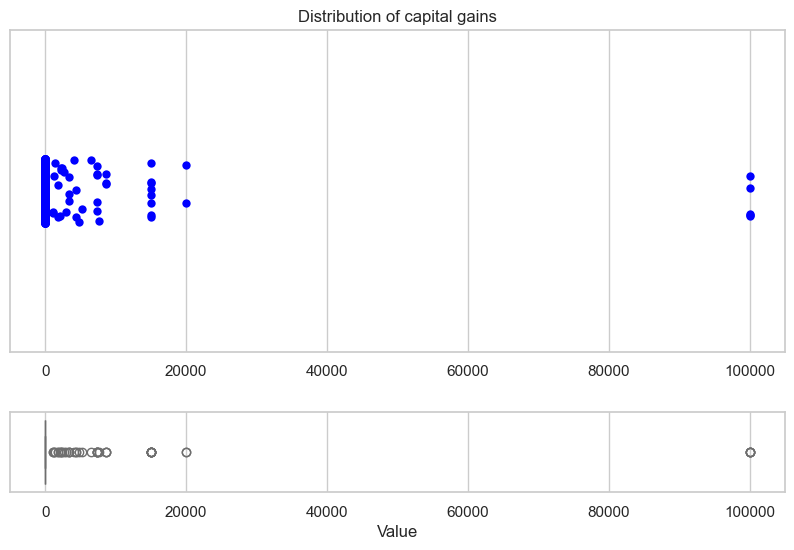

count   196192.00
mean         1.99
std          2.37
min          0.00
25%          0.00
50%          1.00
75%          4.00
max          6.00
Name: num persons worked for employer, dtype: float64


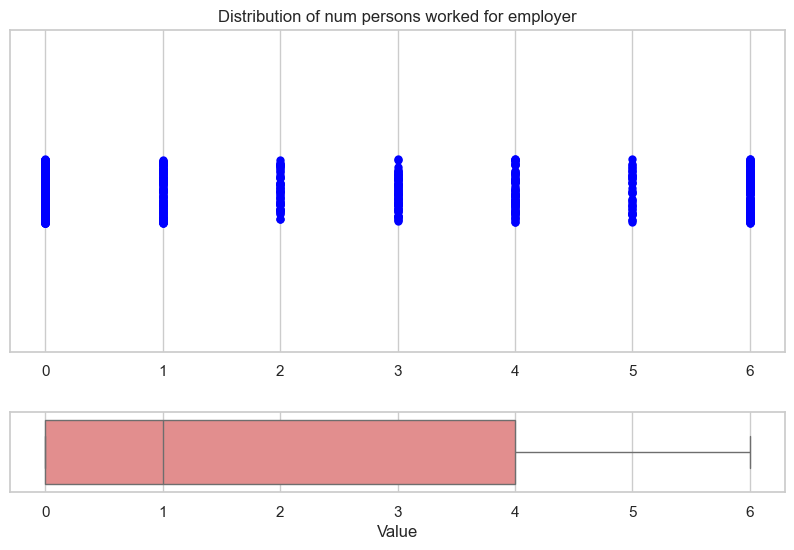

count   196192.00
mean        34.94
std         22.21
min          0.00
25%         16.00
50%         34.00
75%         50.00
max         90.00
Name: age, dtype: float64


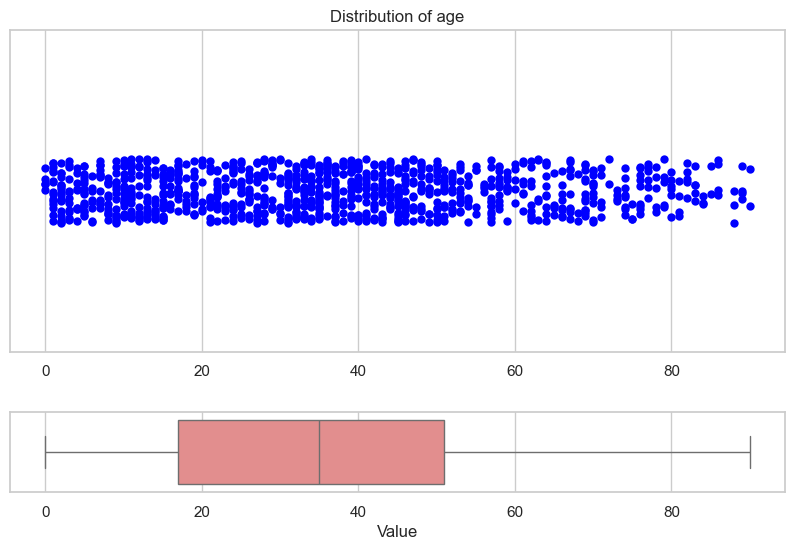

count   196192.00
mean       200.83
std       2000.65
min          0.00
25%          0.00
50%          0.00
75%          0.00
max      99999.00
Name: dividends from stocks, dtype: float64


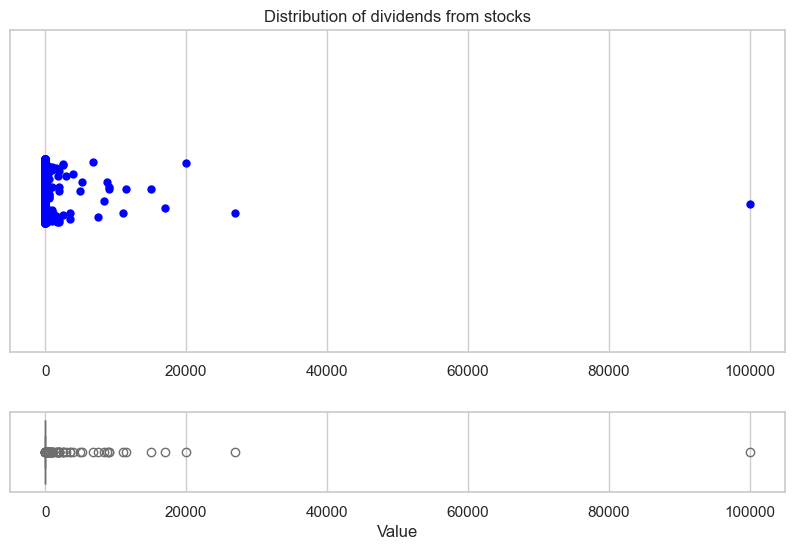

count   196192.00
mean        37.95
std        274.15
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       4608.00
Name: capital losses, dtype: float64


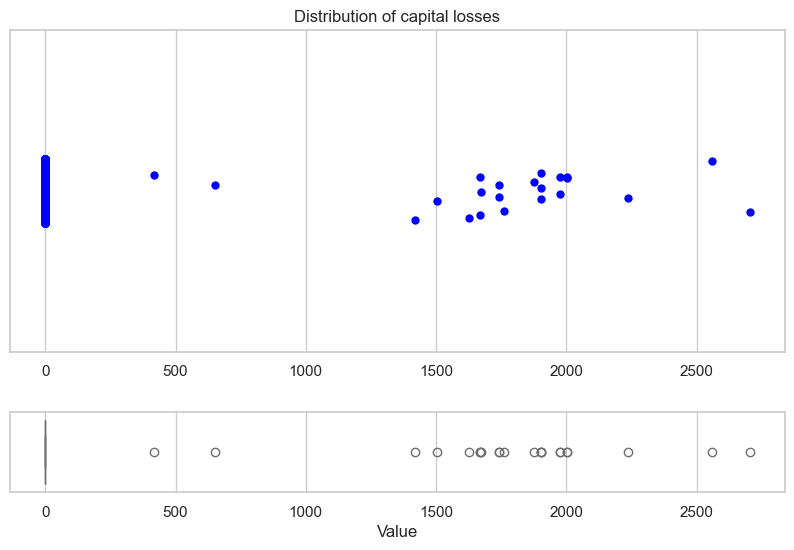

In [11]:
df_sample = df.sample(n=1000, random_state=42) # limiting the sample size to improve readability of graphs
for v in numerical_vars:
    describe = get_numerical_info(df[v])
    print(describe)
    plot_numerical_distribution(df_sample, v)

**3.7** Outliers are values that are far from the usual values that a variable takes, these values may or may not be due to human error and can be identified using several expressions. In our case, we define an outlier as follows:

$$ v \text{ is an outlier} \Leftrightarrow v \in [median - 1.5 * (Q_3 - Q_1), median + 1.5 * (Q_3 - Q_1)]$$

such as: $Q_1$, $median$, and $Q_3$ are the 1st quartile, the median and the 3rd quartile respectively.

In [11]:
for v in numerical_vars:
        outliers = get_outliers(df[v])
        print(v, len(outliers))

age 1806
wage per hour 11303
capital gains 7379
capital losses 3906
dividends from stocks 21138
instance weight 14504
num persons worked for employer 0
weeks worked in year 0


In [12]:
#df = delete_outliers(df, numerical_vars)
#df.head()

**3.8.** Highly correlated variables can be present a problem for prediction models for two reasons:  

1. Highly correlated variables generally represent the same information, causing the model to give a bigger weight and reduces its capacity to exploit the information of the other variables to provide better predictions. This behaviour may cause overfitting.

2. Perfectly or near-perfectly correlated variables can produce unsolvable optimization problems depending on the optimization approach adapted when training the model. e.g. linear regression is unsolvable in this case because the data matrix $X$ is not full rank.

For those reasons, we chose to delete all but one of every set of highly correlated variables. The correlation metric for each type of variables are as follows:

1. For caregorical variables, we use Chi-2 statistical test.
2. For numerical variables, we use Pearson correlation metric.

Pearson's metric is easy to work with since it's value $\in [0, 1]$ which allows us to set an appropriate correlation treshold. Chi-2 test, on the other hand, has values $\in [0, \inf[$ which makes it hard to determin cases of high correlations.

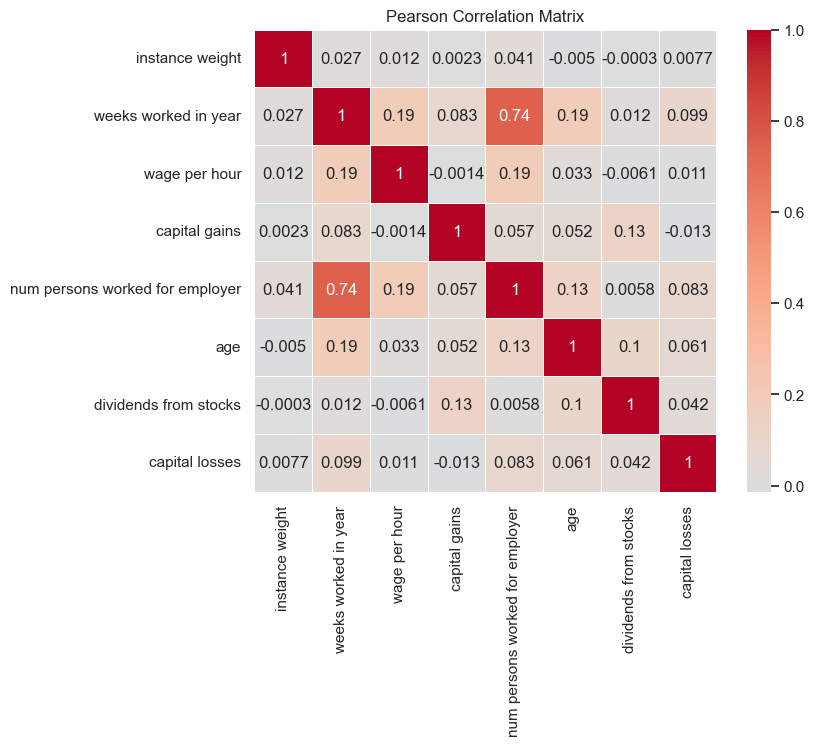

In [12]:
plot_pearson_correlation_matrix(df[numerical_vars])

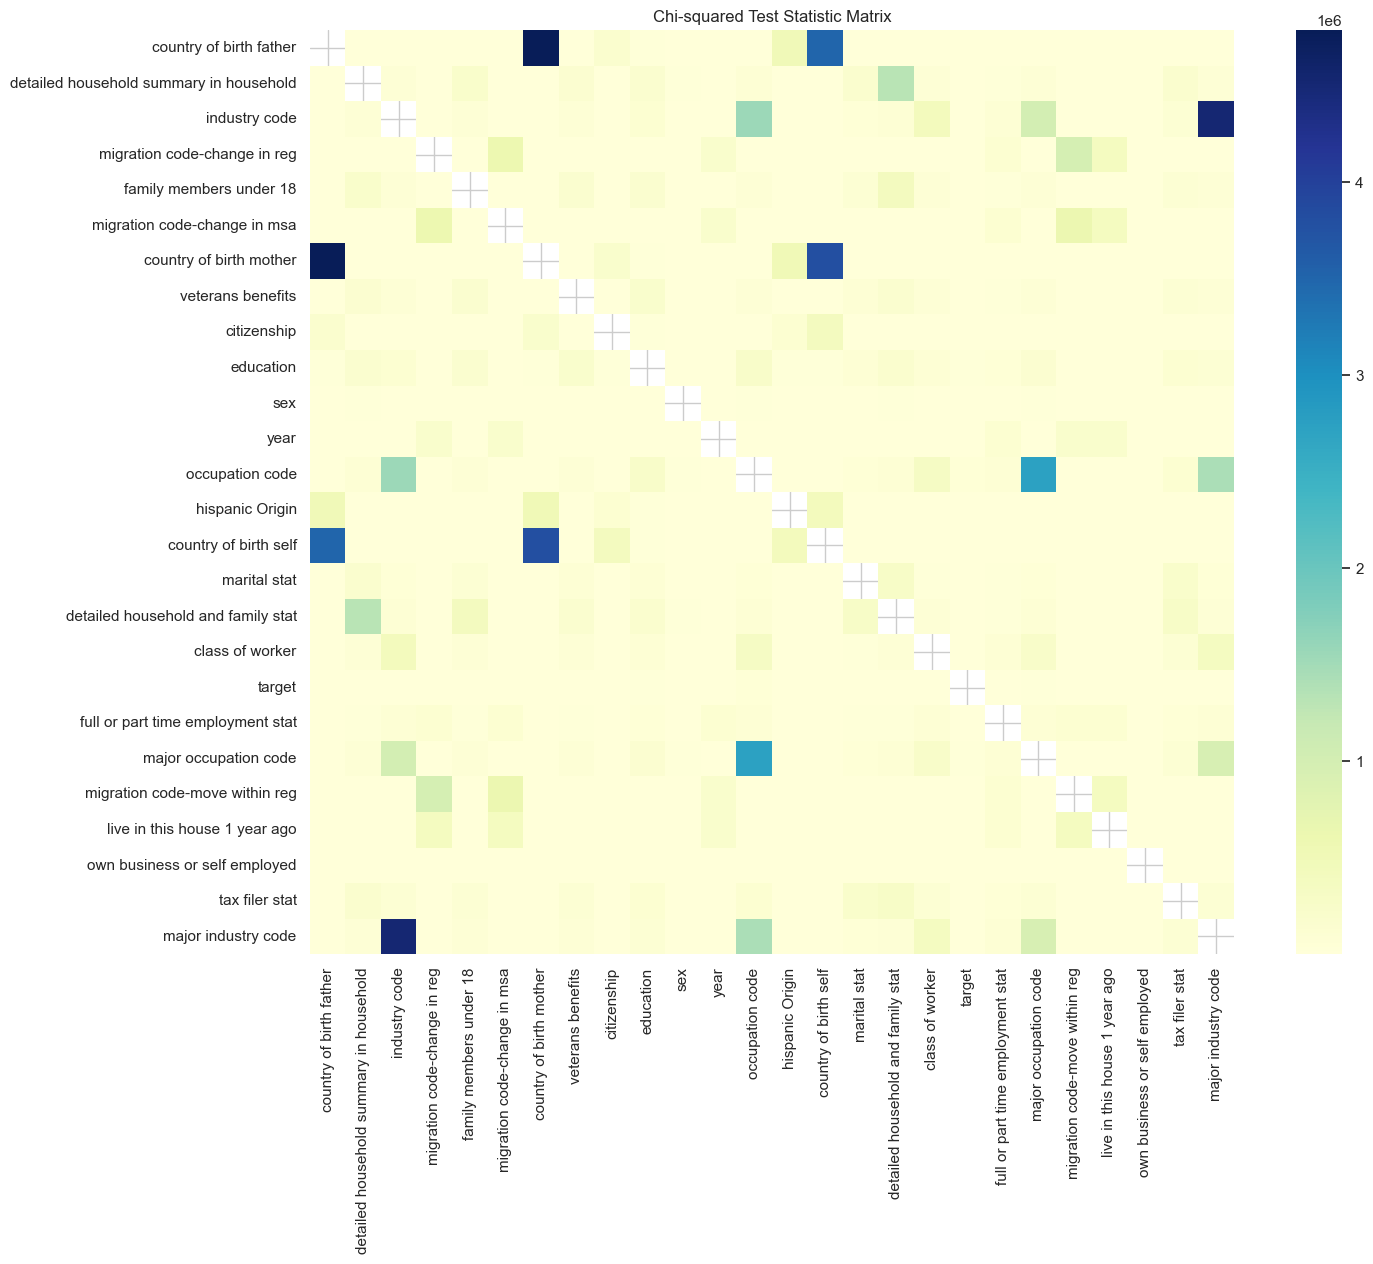

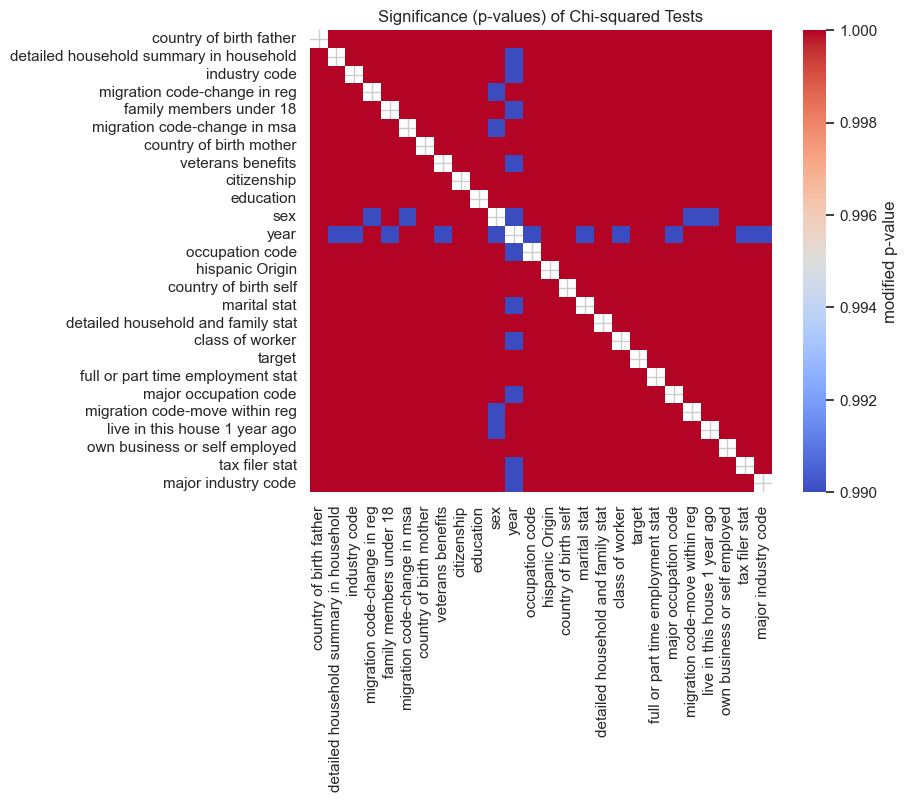

In [13]:
chi2_stat_matrix = plot_chi_2_matrix(df, categorical_vars)

In [14]:
df, numerical_vars = delete_highly_correlated_numeric(df, numerical_vars, pearson_treshold=0.95)

In [15]:
df, categorical_vars = delete_highly_correlated_categoric(df, categorical_vars, chi_2_treshold=1e6)

**3.8.** Categorical variables with a large number of categories can hinder the training of our model making it slow and more complex without an increase in accuracy when many catrgories only have a few samples. For this reason, we choose to group all categories that have a sample percentage less than a predefined treshold as a one category called **"Other"**.

In [16]:
df = group_in_other(df, categorical_vars, grouping_treshold=0.01)

**3.9.** Many classification models only accept numerical features as input. To convert categorical variables into numeric ones, with replace each variable witha one hot encoding and we make sure to remove one of the resulting binary variables to avoid high correlation.

In [18]:
df = one_hot_encoding(df, categorical_vars)

In [19]:
df.head()

,age,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,weeks worked in year,class of worker_ Federal government,class of worker_ Local government,...,own business or self employed_0,own business or self employed_1,own business or self employed_2,veterans benefits_0,veterans benefits_1,veterans benefits_2,year_94,year_95,target_ - 50000.,target_ 50000+.
0,73.00,0.00,0.00,0.00,0.00,1700.09,0.00,0.00,False,False,...,True,False,False,False,False,True,False,True,True,False
1,58.00,0.00,0.00,0.00,0.00,1053.55,1.00,52.00,False,False,...,True,False,False,False,False,True,True,False,True,False
2,18.00,0.00,0.00,0.00,0.00,991.95,0.00,0.00,False,False,...,True,False,False,False,False,True,False,True,True,False
3,9.00,0.00,0.00,0.00,0.00,1758.14,0.00,0.00,False,False,...,True,False,False,True,False,False,True,False,True,False
4,10.00,0.00,0.00,0.00,0.00,1069.16,0.00,0.00,False,False,...,True,False,False,True,False,False,True,False,True,False
